# Callin Switzer
### 6 Nov 2018
___
### - Evaulate weights in network
### - See if some can be set to 0=
### -  Use X-validation to find ideal network size


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
import time
from datetime import datetime
import sys
import csv
import seaborn as sns
import scipy.io
import subprocess
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error

from matplotlib.ticker import ScalarFormatter

import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")

print(sys.version, "\n")

now = datetime.now()
print("last run on " + str(now))

#%qtconsole

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)

if not os.path.exists(savedModels):
    os.mkdir(savedModels)
    
# open file explorer
# aa = r'explorer /select,"'
# subprocess.Popen(str(aa + figDir + '\"'))
# subprocess.Popen(str(aa + dataDir + '\"'))

C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-11-06 14:06:48.714334


In [2]:
# import custom Utils functions
from DeepLearningUtils import *

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-11-06 14:06:48.731289


In [3]:
dataDir2 = r"D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput"

In [4]:
# load dataset
trainDF2 = pd.read_csv(os.path.join(dataDir2, "smallDF.csv"))
trainDF2.head()

,simNum,timestep,F,alpha,phi_0,phi_99,phi_dot_0,phi_dot_99,tau,theta_0,...,x_0,x_99,x_dot_0,x_dot_99,y_0,y_99,y_dot_0,y_dot_99,Fx,Fy
0,0,0,38304.433962,5.340270,3.926991,3.869604,0.000000,-5.674295,10963.268558,0.785398,...,0.000000,6.853314,0.000100,683.734561,0.000000,-1.298536,0.000100,-133.752363,22501.211072,-30998.792903
1,0,1,34264.536249,2.465501,3.948428,4.019544,2.009397,5.425513,72580.767201,0.768478,...,-0.019322,-6.079672,-0.145396,-606.129200,2.520087,6.366770,250.908304,120.273149,-26727.166452,21441.012519
2,0,2,12045.791872,4.573819,3.966608,3.933017,-0.124272,-2.775517,93435.855346,0.768515,...,0.509507,2.986736,52.490438,193.914740,4.834518,2.470847,-18.848146,-211.050011,-1663.845687,-11930.327714
3,0,3,35562.854879,0.767089,4.000007,4.111777,3.434103,7.246049,-96088.338473,0.773977,...,-0.836633,-4.334782,-187.046694,-157.064454,6.838940,17.508792,218.755312,844.589134,25602.909376,24682.132781
4,0,4,20856.636628,2.424378,4.009324,3.995061,-2.309667,0.686804,-27142.805375,0.815904,...,0.429770,2.895126,313.730247,-65.350386,8.392823,6.771320,-58.222983,-102.458917,-15718.389244,13708.812166


# Keras models

In [5]:
# make dataset
X = trainDF2.loc[:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF2.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# # # subtract x_0 and y_0 from everything
# X.x_99 = X.x_99 - X.x_0
# X.y_99 = X.y_99 - X.y_0

# X.x_0 = X.y_0 = 0

In [6]:
X.head()

,x_0,y_0,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.000000,0.000000,3.926991,0.785398,6.853314,-1.298536,3.869604,0.746382,0.000100,0.000100,0.000000,0.000000
1,-0.019322,2.520087,3.948428,0.768478,-6.079672,6.366770,4.019544,0.940422,-0.145396,250.908304,2.009397,0.087406
2,0.509507,4.834518,3.966608,0.768515,2.986736,2.470847,3.933017,0.868402,52.490438,-18.848146,-0.124272,-1.029996
3,-0.836633,6.838940,4.000007,0.773977,-4.334782,17.508792,4.111777,0.747358,-187.046694,218.755312,3.434103,2.037211
4,0.429770,8.392823,4.009324,0.815904,2.895126,6.771320,3.995061,0.761962,313.730247,-58.222983,-2.309667,-0.673328


In [7]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,22501.211072,-30998.792903,10963.268558,683.734561,-133.752363,-5.674295,-4.770986
1,-26727.166452,21441.012519,72580.767201,-606.129200,120.273149,5.425513,10.479995
2,-1663.845687,-11930.327714,93435.855346,193.914740,-211.050011,-2.775517,3.897680
3,25602.909376,24682.132781,-96088.338473,-157.064454,844.589134,7.246049,0.318982
4,-15718.389244,13708.812166,-27142.805375,-65.350386,-102.458917,0.686804,-1.304712


In [8]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [9]:
# scale data 
scalerX = StandardScaler()  
scalerY = StandardScaler()  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [10]:
# double check inverse scaler
pd.DataFrame(scalerY.inverse_transform(Ytrain_scaled)).head()

,0,1,2,3,4,5,6
0,4921.410286,-29472.860520,-43474.926597,567.926777,-88.040935,-4.418419,-7.368523
1,11498.075007,2931.787592,30830.482492,444.337367,2.489686,-2.655246,-0.479400
2,4137.565172,-4224.449916,90265.867970,193.859357,217.524718,-0.423825,5.993808
3,-34932.224981,-25717.453464,38308.396523,12.065647,-910.281258,-3.621573,-0.800979
4,-10521.307892,31032.192025,-79689.073081,-853.024376,208.355764,6.069526,0.281335


In [11]:
pd.DataFrame(Ytrain).reset_index(drop = True).head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,4921.410286,-29472.860520,-43474.926597,567.926777,-88.040935,-4.418419,-7.368523
1,11498.075007,2931.787592,30830.482492,444.337367,2.489686,-2.655246,-0.479400
2,4137.565172,-4224.449916,90265.867970,193.859357,217.524718,-0.423825,5.993808
3,-34932.224981,-25717.453464,38308.396523,12.065647,-910.281258,-3.621573,-0.800979
4,-10521.307892,31032.192025,-79689.073081,-853.024376,208.355764,6.069526,0.281335


In [20]:
# build Keras model with functional API, instead of Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model

from keras import regularizers


# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

# refref: investigate regularization
# refref: add dropout

In [21]:
# inputs = Input(shape=(Xtrain_scaled.shape[1],))

# x = Dense(400, activation='tanh')(inputs)
# x = Dense(400, activation='tanh')(x)
# x = Dense(400, activation='tanh')(x)
# x = Dense(16, activation='tanh')(x)
# predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

# # This creates a model that includes
# # the Input layer and three Dense layers
# model = Model(inputs=inputs, outputs=predictions)
# model.compile(loss="mse", optimizer="adam", metrics = ['mse'])

In [22]:
# earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
#                           verbose=1, mode='auto', min_delta = 0.001)

# history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
#                     verbose = 2, batch_size=2**14, epochs = 1000, 
#                     callbacks = [earlystop])

In [181]:
Xtrain_scaled_small = Xtrain_scaled[0:8000, :]
Ytrain_scaled_small = Ytrain_scaled[0:8000, :]

In [206]:
K.clear_session()


# Small model 
inputs = Input(shape=(Xtrain_scaled_small.shape[1],))

x = Dense(400, activation='tanh', kernel_regularizer=regularizers.l1(0.0001))(inputs)
# x = Dropout(.3)(x)

x = Dense(400, activation='tanh',kernel_regularizer=regularizers.l1(0.0001))(x)
# x = Dropout(.3)(x)

x = Dense(400, activation='tanh', kernel_regularizer=regularizers.l1(0.0001))(x)
x = Dropout(.3)(x)
# x = BatchNormalization()(x)

x = Dense(16, activation='tanh',kernel_regularizer=regularizers.l1(0.0001))(x)
# x = Dropout(.3)(x)

predictions = Dense(Ytrain_scaled_small.shape[1], activation='linear')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss="mse", optimizer="adam", metrics = ['mse'])
# model.set_weights(originalWeights)

In [208]:
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.001)

history = model.fit(Xtrain_scaled_small, Ytrain_scaled_small, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 5000, 
                    callbacks = [earlystop])

Train on 5600 samples, validate on 2400 samples
Epoch 1/5000
 - 0s - loss: 0.0899 - mean_squared_error: 0.0137 - val_loss: 0.0842 - val_mean_squared_error: 0.0082
Epoch 2/5000
 - 0s - loss: 0.0897 - mean_squared_error: 0.0137 - val_loss: 0.0840 - val_mean_squared_error: 0.0082
Epoch 3/5000
 - 0s - loss: 0.0897 - mean_squared_error: 0.0139 - val_loss: 0.0837 - val_mean_squared_error: 0.0081
Epoch 4/5000
 - 0s - loss: 0.0892 - mean_squared_error: 0.0137 - val_loss: 0.0836 - val_mean_squared_error: 0.0082
Epoch 5/5000
 - 0s - loss: 0.0889 - mean_squared_error: 0.0135 - val_loss: 0.0834 - val_mean_squared_error: 0.0082
Epoch 6/5000
 - 0s - loss: 0.0887 - mean_squared_error: 0.0135 - val_loss: 0.0830 - val_mean_squared_error: 0.0080
Epoch 7/5000
 - 0s - loss: 0.0886 - mean_squared_error: 0.0136 - val_loss: 0.0829 - val_mean_squared_error: 0.0081
Epoch 8/5000
 - 0s - loss: 0.0885 - mean_squared_error: 0.0137 - val_loss: 0.0827 - val_mean_squared_error: 0.0081
Epoch 9/5000
 - 0s - loss: 0.088

In [209]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

332535

In [210]:
# set very small weights to 0
for ii in np.arange(2, 7):
    wts[ii][abs(wts[ii]) < 0.0005] = 0

model.set_weights(wts)

nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

17713

In [211]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()

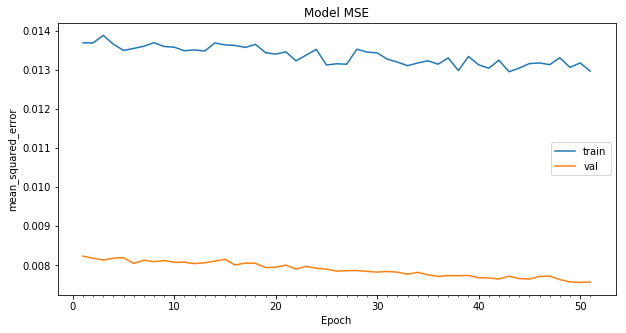

In [212]:
plot_model_history(history, saveFig = False)

In [213]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled_small.shape[0])
ValLoss = model.evaluate(Xtrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :], Ytrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :])
print(ValLoss)

2400/2400 [==============================] - 0s 31us/step
[0.07284220188856125, 0.0076073716518779595]


In [214]:
model.metrics_names 

['loss', 'mean_squared_error']

In [215]:
valLoss = model.evaluate(Xtrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :], 
                           Ytrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])
print(valLoss) ## I'm not sure what the first thing is....

2400/2400 [==============================] - 0s 34us/step
[0.07284220188856125, 0.0076073716518779595]


In [218]:
pp = model.predict(Xtrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])
mean_squared_error(pp, Ytrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])

0.007607371556929382

In [57]:
# Get weights
wts = model.get_weights().copy()

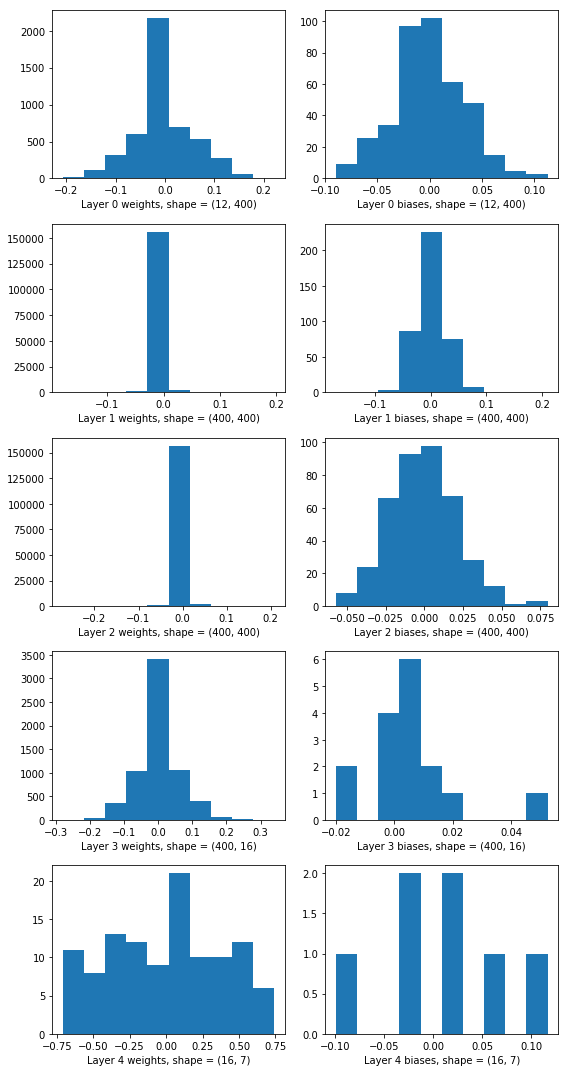

In [58]:
# show weights
plt.close("all")
fig, axs = plt.subplots(5,2, figsize=np.array((8, 15)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1))
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1])
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj].shape))
plt.tight_layout()
# plt.savefig(os.path.join(figDir, "HistogramsOfWeights.png"), dpi = 200)
plt.show()

In [32]:
wts= model.get_weights()
len(wts)

10

In [33]:
wts[1].shape

(400,)

In [34]:
model.layers

In [35]:
first_layer_weights = model.layers[1].get_weights()[0]
first_layer_biases  = model.layers[1].get_weights()[1]
first_layer_weights.shape

(12, 400)

In [36]:
model.layers[0].get_config()


{'batch_input_shape': (None, 12),
 'dtype': 'float32',
 'name': 'input_1',
 'sparse': False}

In [305]:
wts[3].shape

(400,)

(400, 400)


73

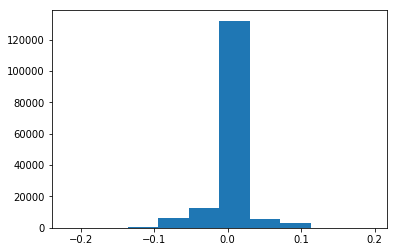

In [283]:
# modify weights
print(wts[2].shape)
wts[2][abs(wts[2]) <= 0.01] = 0
plt.hist(wts[2].reshape(-1))
np.count_nonzero(wts[3])

In [286]:
# set model weights
model.set_weights(wts)


# evaluate loss
valLoss = model.evaluate(Xtrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :], 
                           Ytrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])
print(valLoss)

2400/2400 [==============================] - 0s 35us/step
[0.14641325175762177, 0.14641325175762177]


(array([  1.,   1.,   0.,  17.,  53., 218.,  80.,  26.,   3.,   1.]),
 array([-0.04144997, -0.03409896, -0.02674795, -0.01939695, -0.01204594,
        -0.00469493,  0.00265608,  0.01000708,  0.01735809,  0.0247091 ,
         0.03206011]),
 <a list of 10 Patch objects>)

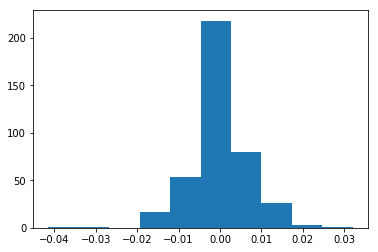

In [287]:
plt.hist(np.reshape(wts[1], -1))

In [161]:
# load model
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [162]:
model.layers

In [163]:
wts= model.get_weights()
len(wts)

10

In [164]:
wts[0].shape

(12, 400)

In [165]:
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

332535

In [78]:
model.evaluate(Xtest_scaled, Ytest_scaled)

2000000/2000000 [==============================] - 55s 27us/step


[5.4791603129910074e-05, 5.4791603129910074e-05]

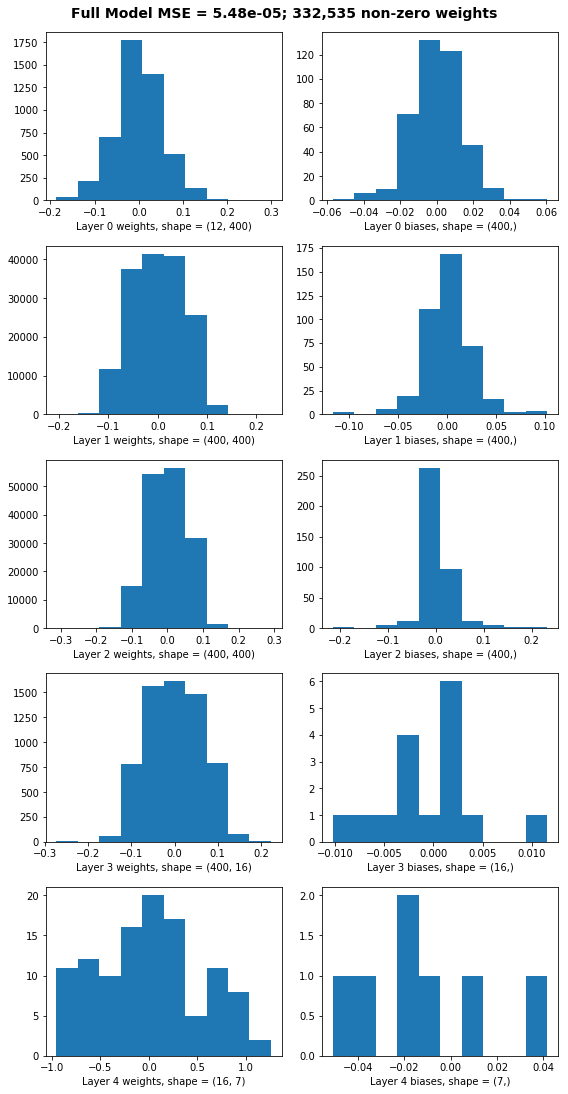

In [122]:
# make histogram of weights
plt.close("all")
fig, axs = plt.subplots(5,2, figsize=np.array((8, 15)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

my_suptitle = fig.suptitle('Full Model MSE = 5.48e-05; 332,535 non-zero weights', fontsize=14, fontweight='bold', y = 1.01)

axs = axs.ravel()

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1))
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1])
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))
plt.tight_layout()
plt.savefig(os.path.join(figDir, "HistogramsOfWeights.png"), dpi = 200,bbox_inches='tight', bbox_extra_artists=[my_suptitle])
plt.show()

In [174]:
# change weights
for ii in np.arange(2, 7):
    wts[ii][abs(wts[ii]) < 0.05] = 0

In [175]:
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

140274

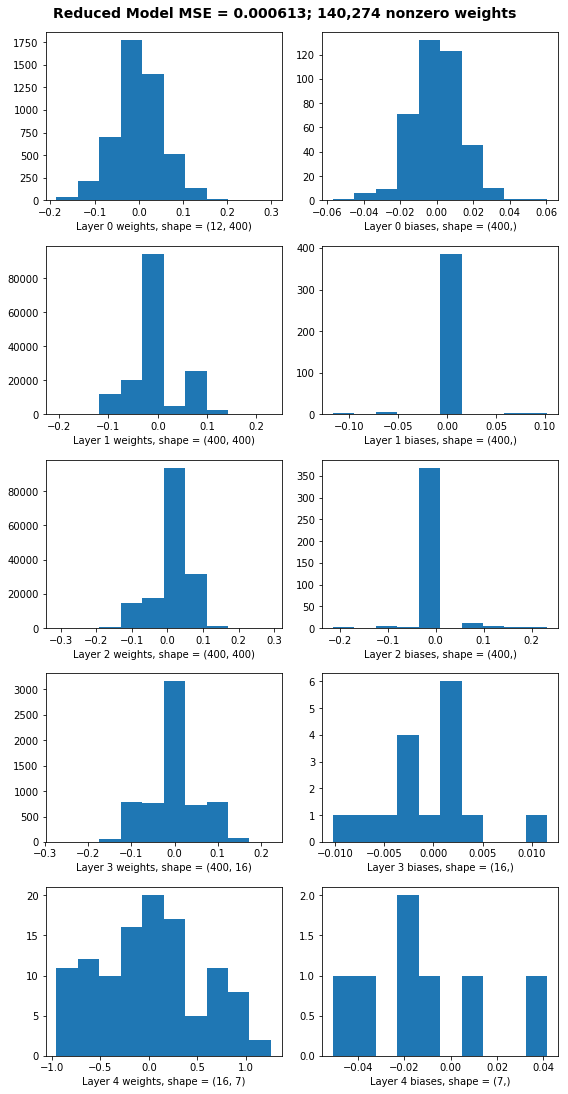

In [176]:
# make histogram of weights
plt.close("all")
fig, axs = plt.subplots(5,2, figsize=np.array((8, 15)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

my_suptitle = fig.suptitle('Reduced Model MSE = 0.000613; 140,274 nonzero weights', fontsize=14, fontweight='bold', y = 1.01)

axs = axs.ravel()

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1))
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1])
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))
plt.tight_layout()
plt.savefig(os.path.join(figDir, "HistogramsOfWeights_updatedWeights_1.png"), dpi = 200,bbox_inches='tight', bbox_extra_artists=[my_suptitle])
plt.show()

In [177]:
# set wts
model.set_weights(wts)

In [178]:
# evaluate with new weights
model.evaluate(Xtest_scaled, Ytest_scaled)

2000000/2000000 [==============================] - 58s 29us/step


[0.10874714509284496, 0.10874714509284496]

In [179]:
nnpreds = model.predict(Xtest_scaled[ :])
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

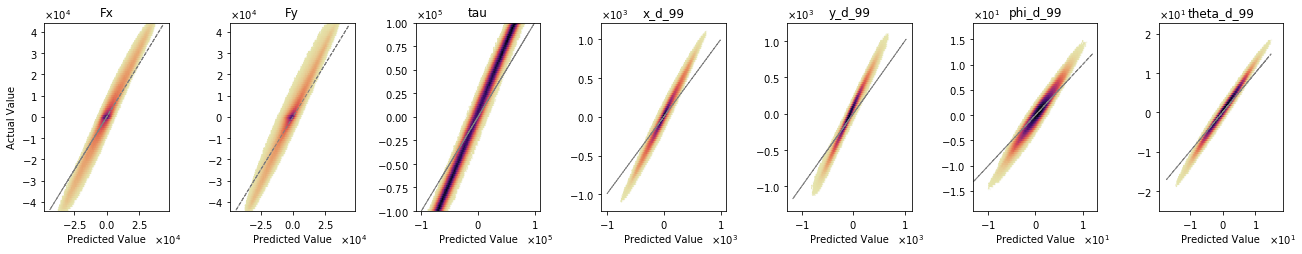

In [180]:
# plot what that looks like
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
        t = axs[ii].xaxis.get_offset_text()
        t.set_x(1.1)
        t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

fig.savefig(os.path.join(figDir, "NNPreds_0Weights.png"), dpi = 500, bbox_inches='tight')


In [158]:
nnpreds = model.predict(Xtest_scaled[ :])

In [18]:
# save model
# model.save(os.path.join(savedModels, 'my_model.h5'))
# aa = r'explorer /select,"'
# subprocess.Popen(str(aa + savedModels + '\"'))

In [159]:
# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

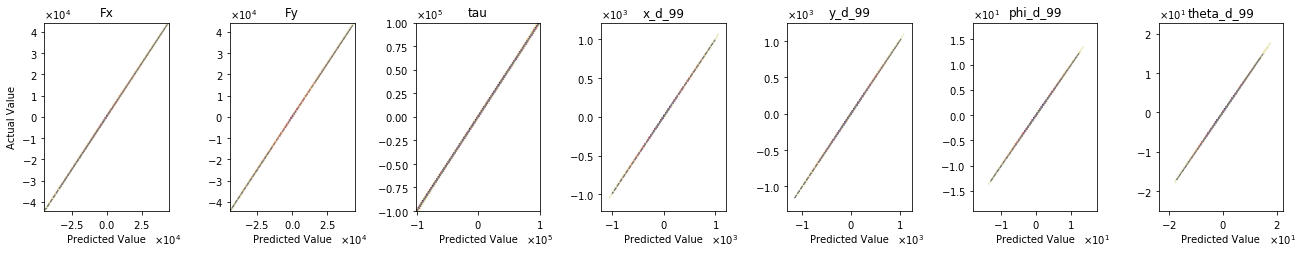

In [107]:
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
        t = axs[ii].xaxis.get_offset_text()
        t.set_x(1.1)
        t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.png"), dpi = 500, bbox_inches='tight')
# fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.svg"),bbox_inches='tight')

# residual plots

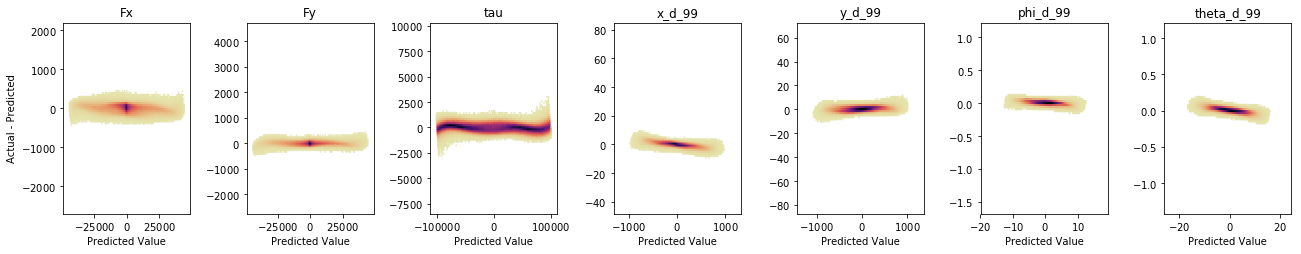

In [110]:
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2


for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#         axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
#         t = axs[ii].xaxis.get_offset_text()
#         t.set_x(1.1)
#         t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual - Predicted")
        axs[ii].set_title(nms2[ii])
        #axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

fig.savefig(os.path.join(figDir, "NNPreds_resids.png"), dpi = 500, bbox_inches='tight')
# fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.svg"),bbox_inches='tight')

In [34]:
nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2 = [nms2[ii].replace("_", "") for ii in range(len(nms2))]
nms2 = [nms2[ii].replace("99", "9") for ii in range(len(nms2))]
nms2 = ["     " + nms2[ii] for ii in range(len(nms2))]
nms2

['     Fx',
 '     Fy',
 '     tau',
 '     xd9',
 '     yd9',
 '     phid9',
 '     thetad9']

YES


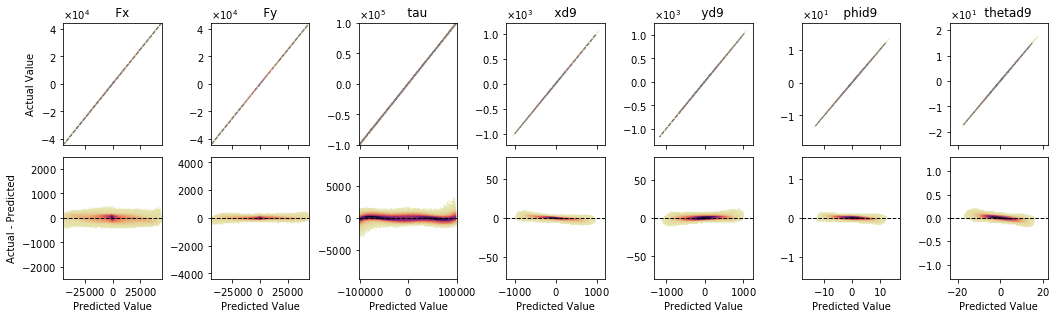

In [38]:
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()


# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
#         axs[ii].set_xlabel("Predicted Value")
#         axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            print("YES")
            axs[jj].set_ylabel("Actual - Predicted")
        #axs[jj].set_title(nms2[ii])
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
#plt.tight_layout()
fig.savefig(os.path.join(figDir, "NNPreds_resids_combined.png"), dpi = 500, bbox_inches='tight')


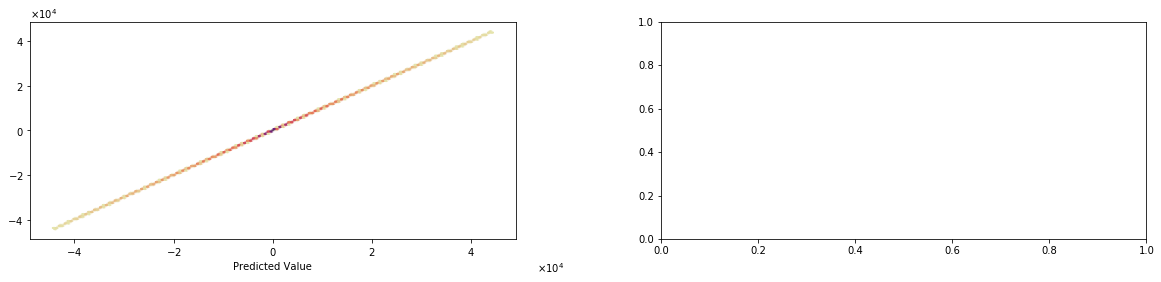

In [97]:
# convert Fx and Fy back to F and alpha

fig, axs = plt.subplots(1,2, figsize=(20, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
ii = 0
axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
axs[ii].set_xlabel("Predicted Value")
axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(0,0))
t = axs[ii].xaxis.get_offset_text()
t.set_x(1.1)
t.set_y(500)



['Fx', 'Fy', 'tau', 'x_d_99', 'y_d_99', 'phi_d_99', 'theta_d_99']

In [101]:
t

Text(1.1,21,'$\\times\\mathdefault{10^{1}}\\mathdefault{}$')

In [19]:
# calculate mean squared error

In [30]:
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

In [36]:
for ii in range(len(nms)):
    #np.sqrt(mean_squared_error(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]))
    print(r2_score(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]), nms[ii])

0.9999506847353872 Fx
0.9999627147331593 Fy
0.9999438044472624 tau
0.9999599609986949 x_dot_99
0.9999467703504513 y_dot_99
0.9999202305164062 phi_dot_99
0.9999309651201447 theta_dot_99


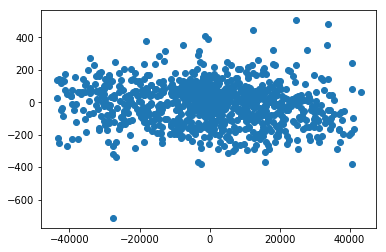

In [28]:
plt.scatter( nnpreds_unscaled[:,ii],Ytest.iloc[0:1000,ii]-  nnpreds_unscaled[:,ii])

In [ ]:
TestPreds = pd.DataFrame(nnpreds_unscaled, columns = Y.columns)
TestPreds.head()

In [ ]:
TestInput = pd.DataFrame(Xtest, columns = X.columns).reset_index(drop = True)
TestInput.head()

In [ ]:
# F will be the same in any quadrant

TestPreds["F"] = np.sqrt(TestPreds["Fx"]**2 + TestPreds["Fy"]**2)

# trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
# trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [ ]:
TestPreds.head()

In [ ]:
# calculate alpha
def quadrant(Fx, Fy):
    if (Fx >= 0) & (Fy >= 0):
        q = 1
    elif (Fx < 0) & (Fy >= 0):
        q = 2
    elif (Fx < 0) & (Fy < 0):
        q = 3
    elif (Fx >= 0) & (Fy < 0):
        q = 4
    else:
        q = 999999
    return(q)



In [ ]:
TestPreds["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(TestPreds["Fx"], TestPreds["Fy"])]

In [ ]:
TestPreds.head()

In [ ]:
def angleCalc(Fx, Fy, q):
    fx = np.abs(Fx)
    fy = np.abs(Fy)
    
    if q == 1:
        alpha = np.arctan(fy/fx)
    elif q == 2:
        alpha = np.pi - np.arctan(fy/fx)
    elif q == 3: 
        alpha = np.pi + np.arctan(fy/fx)
    elif q == 4:
        alpha = (2*np.pi) - np.arctan(fy/fx)
    return(alpha)

In [ ]:
TestPreds["alpha"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(TestPreds["Fx"], TestPreds["Fy"], TestPreds["quadrant"])]

In [ ]:
TestPreds.head()

In [ ]:
TestPredsComb = pd.concat([TestPreds, TestInput], axis = 1)

In [ ]:
TestPredsComb.head()

In [ ]:
TestPredsComb.rename(index=str, columns={"F": "F_pred", "alpha": "alpha_pred", "tau":"tau_pred"}, inplace=True)

In [ ]:
TestPredsComb.head()

In [ ]:
TestPredsComb.drop(['Fx', 'Fy', "quadrant"], axis=1, inplace = True)
TestPredsComb.head()

In [ ]:
cols= ['x_0', 'y_0', 'phi_0', 'theta_0', 
       'x_dot_0', 'y_dot_0', 'phi_dot_0', 'theta_dot_0', 
       'F_pred', 'alpha_pred', 'tau_pred', 
      'x_99', 'y_99', 'phi_99', 'theta_99', 
      'x_dot_99', 'y_dot_99', 'phi_dot_99', 'theta_dot_99' ]

In [ ]:
tc2 = TestPredsComb.loc[:, cols]
tc2.head()

In [ ]:
tc2.rename(columns = {"x_dot_99": "x_dot_99_pred", 
                     "y_dot_99": "y_dot_99_pred", 
                     "theta_dot_99": "theta_dot_99_pred", 
                     "phi_dot_99": "phi_dot_99_pred"}, inplace = True)
tc2.head()

In [ ]:
tc2.to_csv(os.path.join(dataOutput, "NNpreds.csv"), index = False)

In [ ]:
tc2.shape

In [ ]:
Xtrain.shape

In [ ]:

tc_sm =  tc2.sample(n=1000, random_state = 902902)
tc_sm.to_csv(os.path.join(dataOutput, "NNpreds_small.csv"), index = False)

In [ ]:
# check alpha on trainDf
trainDF2["quadrant"] = [quadrant(fx, fy) for fx,fy in zip(trainDF2["Fx"], trainDF2["Fy"])]

trainDF2["alphaCalc"] = [angleCalc(fx, fy, q) for fx, fy, q in zip(trainDF2["Fx"], trainDF2["Fy"], trainDF2["quadrant"])]

In [ ]:
trainDF2.loc[:, ["alpha", "alphaCalc"]].head()

In [ ]:
plt.close("all")
fig, axs = plt.subplots(2,int(len(Y.columns)/2), figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].scatter(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], s = 1, alpha = 0.1 )
        axs[ii].set_xlabel("Predicted Value (un-scaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(un-scaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest.iloc[:,ii], Ytest.iloc[:,ii], 'b')
    except:
        pass

    
fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy.png"), dpi = 120, bbox_inches='tight')

In [ ]:
Ytest.head()

In [ ]:
Xtest.head()

In [ ]:
# refref: idea - predict whole paths, rather than just the endpoint

In [ ]:
plt.close("all")
fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)
fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = ["Fx", "Fy", "tau"]


# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(3):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest_scaled[:,ii],x = nnpreds[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value (scaled)")
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value\n(scaled)")
        axs[ii].set_title(nms[ii])
        axs[ii].plot(Ytest_scaled[:,ii], Ytest_scaled[:,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin.png"), dpi = 120, bbox_inches='tight')

In [ ]:
bf2[['simNum', 'timestep']] = bf2[['simNum', 'timestep']].astype(int)

bf2['count'] = bf2.groupby(["simNum", "timestep"]).cumcount()

bf2.head()

bf2.tail()

sdf = bf2.loc[(bf2["count"] == 0) | (bf2["count"] == 99), :]
sdf.head()

ss = sdf.pivot_table(index='simNum', columns = "count",aggfunc='first')
ss.columns = [f'{i}_{j}' if j != '' else f'{i}' for i,j in ss.columns]
ss["simNum"] = ss.index
ss.index.name = None
ss.head()

np.array(ss).shape

np.vstack([np.array(ss), np.array(ss)]).shape